In [1]:
!nvidia-smi

Fri Mar 17 03:57:00 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:C1:00.0 Off |                    0 |
| N/A   34C    P0    57W / 400W |  40310MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import os 
import glob

path_files = glob.glob("/lustrefs/disk/project/lt900038-ai23tn/frb_data/train/*")
path = Path("/lustrefs/disk/project/lt900038-ai23tn/frb_data/train")

In [3]:
npy_files = sorted(list(path.glob('*.npy')))
csv_files = sorted(list(path.glob('*.csv')))
print(len(csv_files) , len(npy_files))

97 97


In [4]:
csv_files[0] , npy_files[0]

(PosixPath('/lustrefs/disk/project/lt900038-ai23tn/frb_data/train/B0531+21_2020-05-31-11_36_46_0001023_labels.csv'),
 PosixPath('/lustrefs/disk/project/lt900038-ai23tn/frb_data/train/B0531+21_2020-05-31-11_36_46_0001023.npy'))

#pad data .npy to all shape = (262144, 256)

In [6]:
# รอประมาณ 6-10 นาที ถ้า run แบบ front end
data = np.load(npy_files[0])
print("Data shape:", data.shape)
print("Data type:", data.dtype)
print("Data data[0].shape :" , data[0].shape)

file_shapes = []
data_npy = []
max_shape = (262144, 256)
for idx,file in enumerate(npy_files):
    data = np.load(file)
    file_shapes.append(data.shape)
    if data.shape[0] < max_shape[0]:
        pad_width = ((0, max_shape[0]-data.shape[0]), (0, 0))
        print( idx , pad_width)
        data = np.pad(data, pad_width, mode='constant')
        data_npy.append(data)
        continue
    data_npy.append(data)

data_csv = []
max_size = 1024
for file in csv_files:
    df = pd.read_csv(file)
    if len(df["labels"]) < max_size:
        n_missing = max_size - len(df["labels"])
        df_missing = pd.DataFrame({'labels': [0]*n_missing})
        df = pd.concat([df, df_missing], ignore_index=True)
    data_csv.append(df["labels"])
    
# pad ข้อมูลที่ขาดหายไป เป็น 0 ทั้งหมด

data_npy = np.array(data_npy)
print("File shapes:", data_npy.shape)
data_csv = np.array(data_csv)
print("File shapes:", data_csv.shape)

Data shape: (262144, 256)
Data type: float64
Data data[0].shape : (256,)
21 ((0, 7168), (0, 0))
53 ((0, 163072), (0, 0))


In [ ]:
# !pip install --upgrade scipy

In [ ]:
num = 3
print(npy_files[num])
print(csv_files[num])
data_csv[num]

In [9]:
num = 3
print(npy_files[num])
print(csv_files[num])

max_shape = (262144, 256)
data_npy = []
data = np.load(npy_files[num])
if data.shape[0] < max_shape[0]:
    pad_width = ((0, max_shape[0]-data.shape[0]), (0, 0))
    print( idx , pad_width)
    data = np.pad(data, pad_width, mode='constant')
data_npy.append(data)

data_csv = []
max_size = 1024
df = pd.read_csv(csv_files[num])
if len(df["labels"]) < max_size:
    n_missing = max_size - len(df["labels"])
    df_missing = pd.DataFrame({'labels': [0]*n_missing})
    df = pd.concat([df, df_missing], ignore_index=True)
data_csv.append(df["labels"])

/lustrefs/disk/project/lt900038-ai23tn/frb_data/train/B0531+21_2020-05-31-11_36_46_0004095.npy
/lustrefs/disk/project/lt900038-ai23tn/frb_data/train/B0531+21_2020-05-31-11_36_46_0004095_labels.csv


In [99]:
num = 2
path = Path("/lustrefs/disk/project/lt900038-ai23tn/frb_data/train")
npy_files = sorted(list(path.glob('*.npy')))
data = np.load(npy_files[num])
data = data.transpose()
df = pd.read_csv(csv_files[num])
print(data.shape)
print(df["labels"].value_counts())

(256, 262144)
None    1024
Name: labels, dtype: int64


In [100]:
csv = pd.read_csv(csv_files[75])
print(csv["labels"].value_counts())

None            657
Broad           366
Narrow+Broad      1
Name: labels, dtype: int64


(256, 262144)


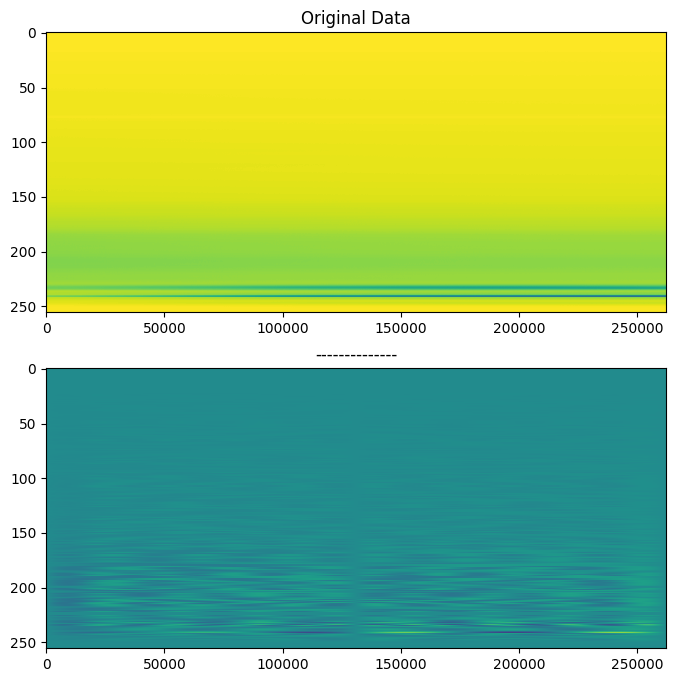

In [101]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

num1 = 75
npy_files1 = sorted(list(path.glob('*.npy')))
data1 = np.load(npy_files[num1])
data1 = data1.transpose()
print(data1.shape)

cov = data1 - data

# Generate FHSS sequence
num_channels = 10 #10
hop_sequence = np.random.randint(0, num_channels, size=cov.shape[0])

# Modulate data using FHSS sequence
hop_matrix = np.zeros((num_channels, cov.shape[1]))
for i in range(num_channels):
    hop_matrix[i] = np.sin(2*np.pi*i*np.arange(cov.shape[1])/cov.shape[1])
fhss_data = np.zeros(cov.shape)
for i in range(cov.shape[0]):
    fhss_data[i] = hop_matrix[hop_sequence[i]] * cov[i]

# Plot original and FHSS-modulated data
fig, axs = plt.subplots(2, 1, figsize=(8, 8))
axs[0].set_title("Original Data")
axs[0].imshow(cov, aspect='auto')

axs[1].set_title("--------------")
axs[1].imshow(fhss_data, aspect='auto')
# axs[1].imshow(fhss_data.T, aspect='auto')
# axs[1].set_title("FHSS-Modulated Data")
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Set up paths
path = Path("/lustrefs/disk/project/lt900038-ai23tn/frb_data/train")
npy_files = sorted(list(path.glob('*.npy')))
csv_files = sorted(list(path.glob('*.csv')))
num = 6

# Load data
data = np.load(npy_files[num])
df_labels = pd.read_csv(csv_files[num])

# Check data shape and type
print("Data shape:", data.shape)
print("Data type:", data.dtype)

# Check label shape and type
print("Label shape:", df_labels.shape)
print("Label type:", df_labels.dtypes)

# Remove any NaNs
data = np.nan_to_num(data)

# Normalize the data
scaler = StandardScaler()
data = scaler.fit_transform(data)

# Split data into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(data, df_labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


In [135]:
import numpy as np
from pathlib import Path
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

num = 6
path = Path("/lustrefs/disk/project/lt900038-ai23tn/frb_data/train")
npy_files = sorted(list(path.glob('*.npy')))
data = np.load(npy_files[num])
df_labels = pd.read_csv(csv_files[num])

print("Data shape:", data.shape)
print("Data type:", data.dtype)
print("Label shape:", df_labels.shape)
print("Label type:", df_labels.dtypes)

# Repeat labels to match number of samples in data array
df_labels = pd.concat([df_labels]*256, ignore_index=True)

# Normalize data
scaler = StandardScaler()
data = scaler.fit_transform(data)

# Split data into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(data, df_labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print("Number of training samples:", len(X_train))
print("Number of validation samples:", len(X_val))
print("Number of test samples:", len(X_test))



Data shape: (262144, 256)
Data type: float64
Label shape: (1024, 3)
Label type: Unnamed: 0     int64
index          int64
labels        object
dtype: object
Number of training samples: 167772
Number of validation samples: 41943
Number of test samples: 52429


In [140]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

path = Path("/lustrefs/disk/project/lt900038-ai23tn/frb_data/train")
npy_files = sorted(list(path.glob('*.npy')))

In [ ]:
import numpy as np
from pathlib import Path

path = Path("/lustrefs/disk/project/lt900038-ai23tn/frb_data/train")
csv_files = sorted(list(path.glob('*.csv')))

max_size = 256
for file in csv_files:
    df = pd.read_csv(file)
    if len(df["labels"]) == max_size:
        continue
    data = pd.to_numeric(df["labels"], errors="coerce")
    new_n = int(len(data)/4)
    new_data = np.zeros(new_n)
    for i in range(new_n):
        new_data[i] = np.max(data[i*4:(i+1)*4])
    # print(new_data)
    df["labels"] = new_data

df["labels"]


(-0.5, 255.5, 124.5, -0.5)

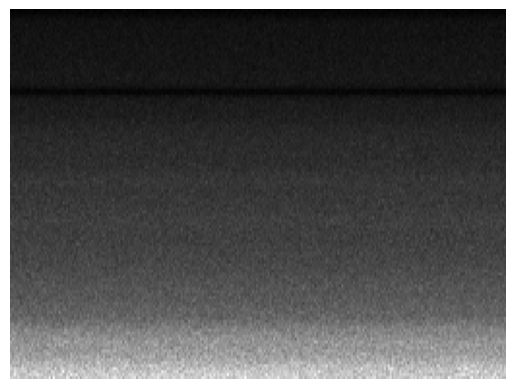

In [28]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

path = Path("/lustrefs/disk/project/lt900038-ai23tn/frb_data/train")
save_file = Path("/home/superai052/super_workspace/Data_train/data_gray_x50to175")
npy_files = sorted(list(path.glob('*.npy')))

step = 2*256
num = 25
# for path_name in npy_files:
data = np.load(npy_files[num])
data = data.transpose()
name = npy_files[num].name.split(".")[0] + ".png"
# print(name)
# df = pd.read_csv(csv_files[num])
data_cropped = data[50:175,step:step+256]
# print(data.shape)
# print(data_cropped.shape)
plt.imshow(data_cropped, cmap='gray', aspect='auto')
plt.axis('off')
# plt.savefig(f"super_workspace/Data_train/data_gray_x50to175/{name}", dpi=300, bbox_inches='tight', pad_inches=0)
        
    # plt.savefig(save_file / ( name + ".png" ), dpi=300, bbox_inches='tight', pad_inches=0)
    # print(df["labels"].value_counts())
    # print(df["labels"].value_counts())

In [63]:
num = 2
path = Path("/lustrefs/disk/project/lt900038-ai23tn/frb_data/train")
npy_files = sorted(list(path.glob('*.npy')))
NOISE = np.load(npy_files[num])
NOISE = NOISE.transpose()
df = pd.read_csv(csv_files[num])
print(NOISE.shape)
print(df["labels"].value_counts())

(256, 262144)
None    1024
Name: labels, dtype: int64


<function matplotlib.pyplot.show(close=None, block=None)>

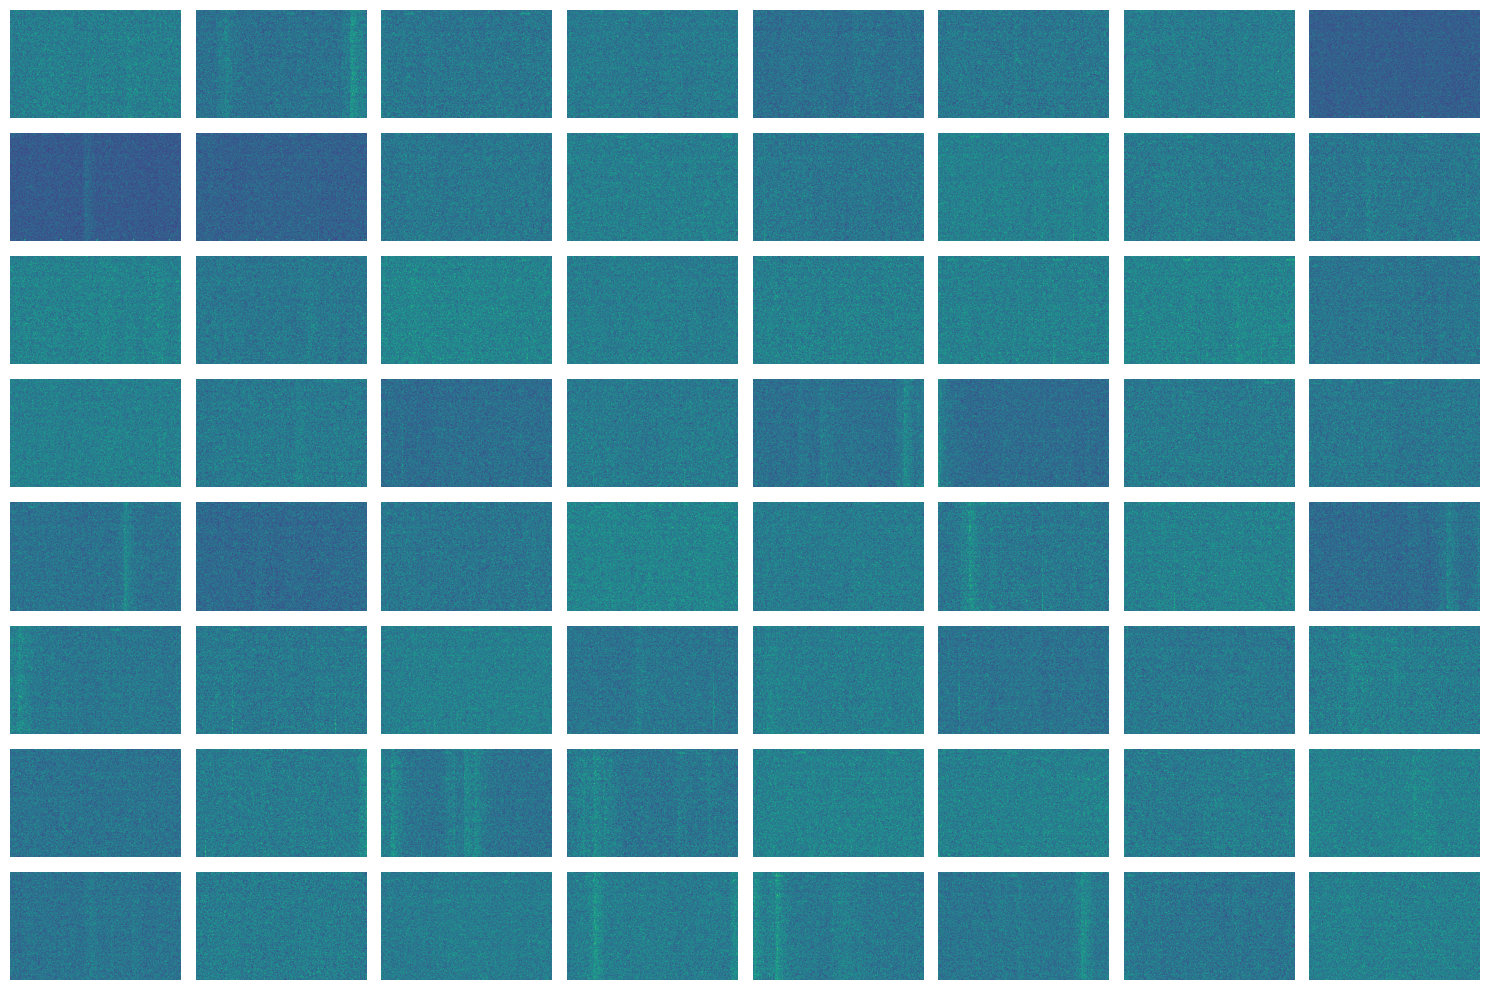

In [100]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

path = Path("/lustrefs/disk/project/lt900038-ai23tn/frb_data/train")
npy_files = sorted(list(path.glob('*.npy')))

step_lo = 0*256
num = 74
data = np.load(npy_files[num])
data = data.transpose()
data = data / 2

n_rows = 8
n_cols = 8

fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 10))

for i in range(n_rows):
    for j in range(n_cols):
        step = (i * n_cols + j) * 256
        data_cropped = data[:, step_lo+step:step_lo+step + 256]
        axs[i, j].imshow(data_cropped, aspect='auto') #, cmap='gray'
        axs[i, j].axis('off')

plt.tight_layout()
plt.show


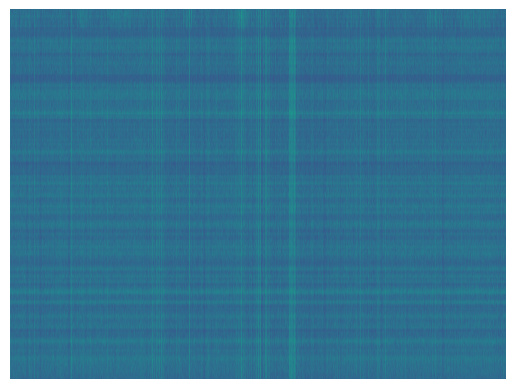

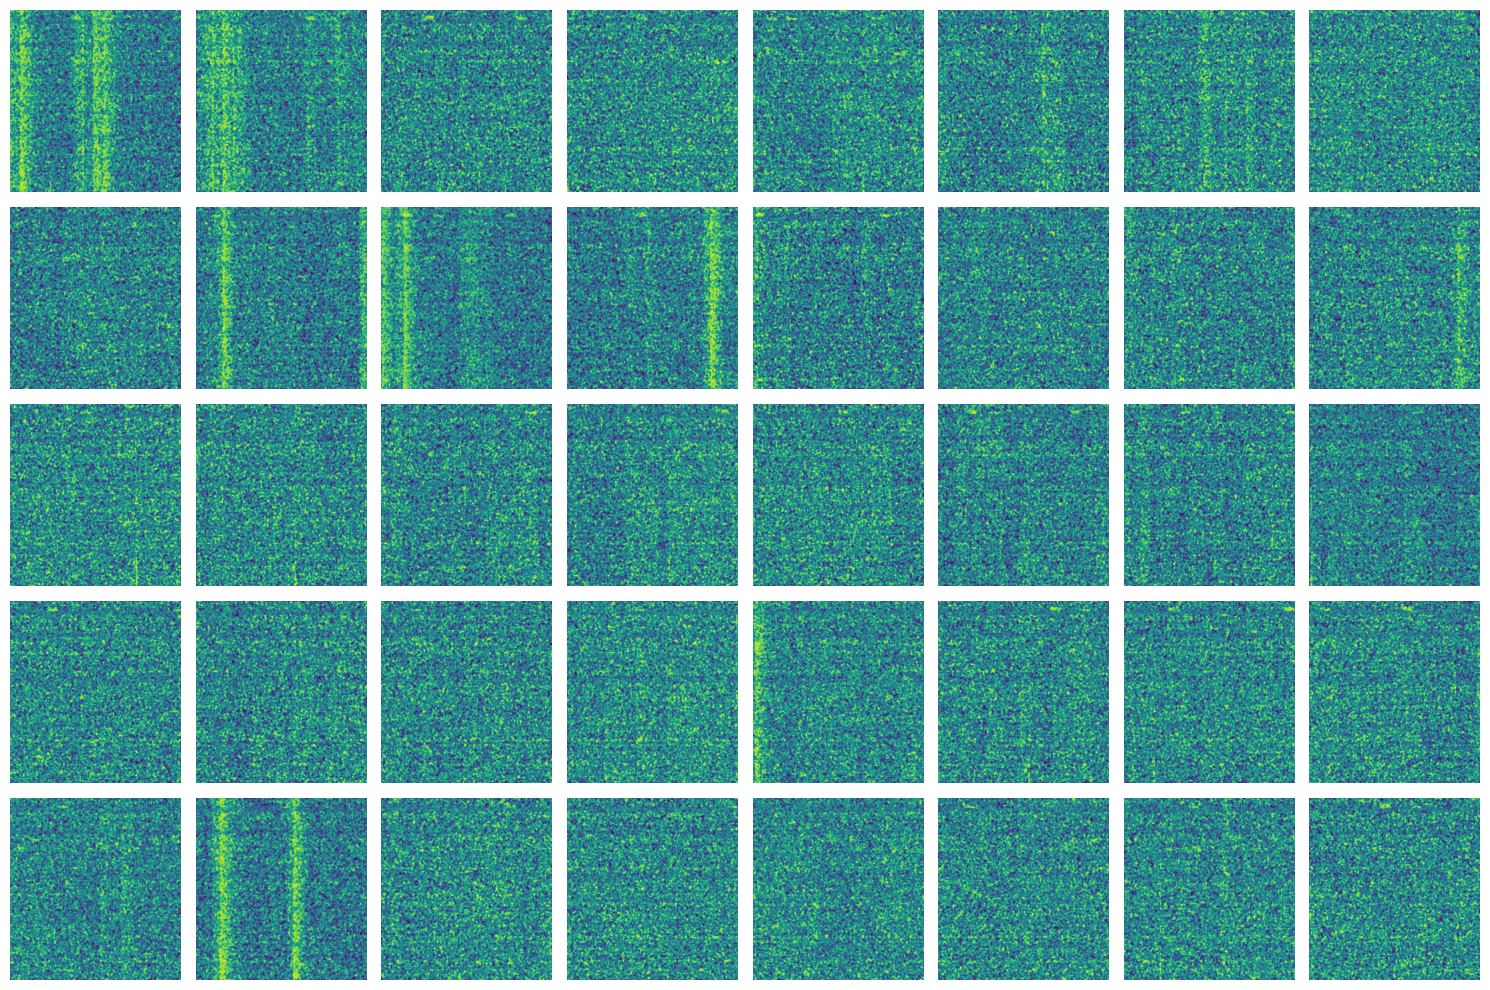

In [9]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from skimage.exposure import equalize_adapthist

def normalize_data(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def apply_gaussian_filter(data, sigma=0.8):
    return gaussian_filter(data, sigma)

def enhance_features(data):
    return equalize_adapthist(data)

path = Path("/lustrefs/disk/project/lt900038-ai23tn/frb_data/train")
npy_files = sorted(list(path.glob('*.npy')))

step_lo = 50*256
num = 74
data = np.load(npy_files[num])
data = data.transpose()
enhanced_data = enhance_features(apply_gaussian_filter(normalize_data(data)))

plt.imshow(enhanced_data, aspect='auto') #, cmap='gray'
plt.axis('off')

n_rows = 5
n_cols = 8


fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 10))

for i in range(n_rows):
    for j in range(n_cols):
        step = (i * n_cols + j) * 256
        data_cropped = enhanced_data[:, step_lo+step:step_lo+step + 256]
        axs[i, j].imshow(data_cropped, aspect='auto') #, cmap='gray'
        axs[i, j].axis('off')

plt.tight_layout()
plt.show()


In [5]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

path = Path("/lustrefs/disk/project/lt900038-ai23tn/frb_data/train")
npy_files = sorted(list(path.glob('*.npy')))
csv_files = sorted(list(path.glob('*.csv')))
column_names = ['Path', 'idx', 'pulse', 'broad', 'narrow', 'labels']
data_csv = {
    'Path': [],'idx': [],'Narrow': [],'Pulse': [],'Broad': [],'labels': []
}

data_list_csv = 1024
for num, file_path in enumerate(npy_files):
    print(num)
    data = np.load(file_path)
    csv = pd.read_csv(csv_files[num])["labels"]
    name = file_path.name.split(".")[0] + ".png"
    data = data.transpose()
    # fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 10))

    for i in range(data_list_csv):
        step = i * 256
        data_cropped = data[:, step:step + 256]
        if i % 300 == 0:
            print(i)
        output_file_name = f"/home/superai052/super_workspace/Data_train/data_sub_image/image/{i}-{name}"
        data_csv['Path'].extend([output_file_name])
        data_csv['idx'].extend([i])
        data_csv['Narrow'].extend([csv[i] == "Narrow"])
        data_csv['Pulse'].extend([csv[i] == "Pulse"])
        data_csv['Broad'].extend([csv[i] == "Broad"])
        data_csv['labels'].extend([''.join([str(int("Pulse" in x)),str(int("Broad" in x)),str(int("Narrow" in x))]) for x in [csv[i]]])

        plt.imshow(data_cropped, aspect='auto')
        plt.axis('off')
        plt.savefig(output_file_name, dpi=300, bbox_inches='tight', pad_inches=0)
        
    plt.tight_layout()
    plt.close(fig)

df = pd.DataFrame(data, columns=column_names)
df.to_csv('data.csv', index=False)

0


In [ ]:
# subimage gray
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
from scipy.ndimage import gaussian_filter
from skimage.exposure import equalize_adapthist
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm

def normalize_data(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def apply_gaussian_filter(data, sigma=0.8):
    return gaussian_filter(data, sigma)

def enhance_features(data):
    return equalize_adapthist(data)

def save_image(data_cropped, output_file_name):
    im = Image.fromarray((data_cropped * 255).astype(np.uint8))
    im.save(output_file_name)

def process_data(i, data, csv, name, data_csv):
    step = i * 256
    data_cropped = data[:, step:step + 256]
    output_file_name = f"/home/superai052/super_workspace/Data_train/data_sub_image/image/{i}-{name}"
    data_csv['Path'].extend([output_file_name])
    data_csv['idx'].extend([i])
    data_csv['Narrow'].extend([csv[i] == "Narrow"])
    data_csv['Pulse'].extend([csv[i] == "Pulse"])
    data_csv['Broad'].extend([csv[i] == "Broad"])
    data_csv['labels'].extend([''.join([str(int("Pulse" in x)), str(int("Broad" in x)), str(int("Narrow" in x))]) for x in [csv[i]]])

    save_image(data_cropped, output_file_name)
    return data_csv

path = Path("/lustrefs/disk/project/lt900038-ai23tn/frb_data/train")
npy_files = sorted(list(path.glob('*.npy')))
csv_files = sorted(list(path.glob('*.csv')))
column_names = ['Path', 'idx', 'pulse', 'broad', 'narrow', 'labels']
data_csv = {
    'Path': [], 'idx': [], 'Narrow': [], 'Pulse': [], 'Broad': [], 'labels': []
}

data_list_csv = 1024
for num, file_path in tqdm(enumerate(npy_files), total=len(npy_files)):
    data = np.load(file_path)
    csv = pd.read_csv(csv_files[num])["labels"]
    name = file_path.name.split(".")[0] + ".png"
    data = data.transpose()
    data = enhance_features(apply_gaussian_filter(normalize_data(data)))

    with ProcessPoolExecutor(max_workers=12) as executor:
        results = list(executor.map(process_data, range(data_list_csv), [data]*data_list_csv, [csv]*data_list_csv, [name]*data_list_csv, [data_csv]*data_list_csv))

    for res in results:
        for key in data_csv:
            data_csv[key].extend(res[key])

df = pd.DataFrame(data_csv, columns=column_names)
df.to_csv('data.csv', index=False)


In [24]:
[''.join([str(int("Pulse" in x)), str(int("Broad" in x)), str(int("Narrow" in x))]) for x in ["PulseBroadNarrow"]]

['111']

In [25]:
zxc['labels']

0        None
1        None
2        None
3       Broad
4        None
        ...  
1019     None
1020     None
1021     None
1022     None
1023     None
Name: labels, Length: 1024, dtype: object

In [26]:
csv_files = sorted(list(path.glob('*.csv')))
column_names = ['Path', 'idx', 'pulse', 'broad', 'narrow', 'labels']
data_csv = {
    'Path': [], 'idx': [], 'pulse': [], 'broad': [], 'narrow': [], 'labels': []
}
zxc = pd.read_csv(csv_files[75])
for idx, label in enumerate(zxc['labels']):
    data_csv['Path'].append("1234")
    data_csv['idx'].append(idx)
    data_csv['pulse'].append(label == "Pulse")
    data_csv['broad'].append(label == "Broad")
    data_csv['narrow'].append(label == "Narrow")
    data_csv['labels'].extend([''.join([str(int("Pulse" in x)), str(int("Broad" in x)), str(int("Narrow" in x))]) for x in [label]])

df = pd.DataFrame(data_csv, columns=column_names)
df.to_csv('data.csv', index=False)


In [ ]:
###########@@@@@ RBG
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
from scipy.ndimage import gaussian_filter
from skimage.exposure import equalize_adapthist
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm

def normalize_data(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def apply_gaussian_filter(data, sigma=0.8):
    return gaussian_filter(data, sigma)

def enhance_features(data):
    return equalize_adapthist(data)

def save_image(data_cropped, output_file_name):
    plt.imshow(data_cropped, aspect='auto')
    plt.axis('off')
    plt.savefig(output_file_name, dpi=200, bbox_inches='tight', pad_inches=0)
    plt.close()

def process_data(i, data, csv, name, data_csv):
    step = i * 256
    data_cropped = data[:, step:step + 256]
    output_file_name = f"/home/superai052/super_workspace/Data_train/data_sub_image/image/{i}-{name}"
    data_csv['Path'].extend([output_file_name])
    data_csv['idx'].extend([i])
    data_csv['pulse'].append(label == "Pulse")
    data_csv['broad'].append(label == "Broad")
    data_csv['narrow'].append(label == "Narrow")
    data_csv['labels'].extend([''.join([str(int("Pulse" in x)), str(int("Broad" in x)), str(int("Narrow" in x))]) for x in [csv[i]]])

    save_image(data_cropped, output_file_name)
    return data_csv

path = Path("/lustrefs/disk/project/lt900038-ai23tn/frb_data/train")
npy_files = sorted(list(path.glob('*.npy')))
csv_files = sorted(list(path.glob('*.csv')))
column_names = ['Path', 'idx', 'pulse', 'broad', 'narrow', 'labels']
data_csv = {
    'Path': [], 'idx': [], 'pulse': [], 'broad': [], 'narrow': [], 'labels': []
}

data_list_csv = 1024
for num, file_path in tqdm(enumerate(npy_files), total=len(npy_files)):
        data = np.load(file_path)
        csv = pd.read_csv(csv_files[num])["labels"]
        name = file_path.name.split(".")[0] + ".png"
        data = data.transpose()
        data = enhance_features(apply_gaussian_filter(normalize_data(data)))

        with ProcessPoolExecutor(max_workers=10) as executor:
            results = list(executor.map(process_data, range(data_list_csv), [data]*data_list_csv, [csv]*data_list_csv, [name]*data_list_csv, [data_csv]*data_list_csv))
        
        if num % 2 == 0:
            df = pd.DataFrame(data_csv, columns=column_names)
            df.to_csv('data.csv', index=False)

        for res in results:
            for key in data_csv:
                data_csv[key].extend(res[key])

df = pd.DataFrame(data_csv, columns=column_names)
df.to_csv('/home/superai052/super_workspace/data.csv', index=False)


In [8]:
###########@@@@@ RBG
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
from scipy.ndimage import gaussian_filter
from skimage.exposure import equalize_adapthist
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm

def normalize_data(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def apply_gaussian_filter(data, sigma=0.8):
    return gaussian_filter(data, sigma)

def enhance_features(data):
    return equalize_adapthist(data)

def save_image(data_cropped, output_file_name):
    plt.imshow(data_cropped, aspect='auto')
    plt.axis('off')
    plt.savefig(output_file_name, dpi=200, bbox_inches='tight', pad_inches=0)
    plt.close()

def process_data(i, data, csv, name, data_csv):
    step = i * 256
    data_cropped = data[:, step:step + 256]
    output_file_name = f"/home/superai052/super_workspace/Data_train/data_sub_image/image/{i}-{name}"
    data_csv['Path'].extend([output_file_name])
    data_csv['idx'].extend([i])
    data_csv['Narrow'].extend([csv[i] == "Narrow"])
    data_csv['Pulse'].extend([csv[i] == "Pulse"])
    data_csv['Broad'].extend([csv[i] == "Broad"])
    data_csv['labels'].extend([''.join([str(int("Pulse" in x)), str(int("Broad" in x)), str(int("Narrow" in x))]) for x in [csv[i]]])

    save_image(data_cropped, output_file_name)
    return data_csv

path = Path("/lustrefs/disk/project/lt900038-ai23tn/frb_data/train")
npy_files = sorted(list(path.glob('*.npy')))
csv_files = sorted(list(path.glob('*.csv')))
column_names = ['Path', 'idx', 'pulse', 'broad', 'narrow', 'labels']
data_csv = {
    'Path': [], 'idx': [], 'Narrow': [], 'Pulse': [], 'Broad': [], 'labels': []
}

data_list_csv = 1024
for num, file_path in tqdm(enumerate(npy_files), total=len(npy_files)):
    data = np.load(file_path)
    csv = pd.read_csv(csv_files[num])["labels"]
    name = file_path.name.split(".")[0] + ".png"
    data = data.transpose()
    data = enhance_features(apply_gaussian_filter(normalize_data(data)))

    with ProcessPoolExecutor(max_workers=10) as executor:
        results = list(executor.map(process_data, range(data_list_csv), [data]*data_list_csv, [csv]*data_list_csv, [name]*data_list_csv, [data_csv]*data_list_csv))
    
    if num % 1 == 0:
        df = pd.DataFrame(data_csv, columns=column_names)
        df.to_csv('/home/superai052/super_workspace/Data_train/data.csv', index=False)
    
    for res in results:
        for key in data_csv:
            data_csv[key].extend(res[key])

df = pd.DataFrame(data_csv, columns=column_names)
df.to_csv('/home/superai052/super_workspace/Data_train/data.csv', index=False)


  2%|██                                                                                                    | 2/97 [12:42<10:07:22, 383.60s/it]

In [ ]:
#basic image
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from skimage.exposure import equalize_adapthist
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm import tqdm

def normalize_data(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def apply_gaussian_filter(data, sigma=0.8):
    return gaussian_filter(data, sigma)

def enhance_features(data):
    return equalize_adapthist(data)

def process_and_save_image(npy_path, expected_shape):
    name = npy_path.name.split(".")[0] + ".png"
    data = np.load(npy_path)
    data = data.transpose()

    # Check the data shape
    if data.shape != expected_shape:
        print(f"Skipping {name}: data shape {data.shape} does not match expected shape {expected_shape}")
        return

    enhanced_data = enhance_features(apply_gaussian_filter(normalize_data(data)))
    plt.imshow(enhanced_data, aspect='auto')
    plt.axis('off')
    plt.savefig(f"/home/superai052/super_workspace/Data_train/preprocess_image/{name}", dpi=200, bbox_inches='tight', pad_inches=0)
    plt.close()

path = Path("/lustrefs/disk/project/lt900038-ai23tn/frb_data/train")
npy_files = sorted(list(path.glob('*.npy')))

expected_shape = (256, 262144)
with ProcessPoolExecutor(max_workers=6) as executor:
    futures = {executor.submit(process_and_save_image, npy_file, expected_shape): npy_file for npy_file in npy_files}
    for future in tqdm(as_completed(futures), total=len(npy_files), desc="Processing images"):
        pass


import shutil
from pathlib import Path

source_path = Path("/lustrefs/disk/project/lt900038-ai23tn/frb_data/train")
destination_path = Path("/home/superai052/super_workspace/Data_train/preprocess_image")

csv_files = sorted(list(source_path.glob('*.csv')))
for csv_file in csv_files:
    shutil.copy(csv_file, destination_path / csv_file.name)